# Official

Loss @ 4999 => 0.003084: 100%|██████████| 5000/5000 [01:08<00:00, 72.90it/s]


Basis 1: W = [0.10734946] mu = -0.22197525203227997 sigma = 0.09246796369552612 bias = 0.14100301265716553
Basis 2: W = [0.93542385] mu = 0.2778133451938629 sigma = -0.18075409531593323 bias = 0.14100301265716553
Basis 3: W = [-1.0855271] mu = 0.7345882654190063 sigma = 0.23043975234031677 bias = 0.14100301265716553


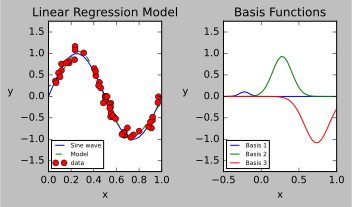

In [54]:
# Ravindra Bisram 
# ECE-472 Deep Learning HW 1
# Modified example code from Professor Curro
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import os
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Ended up removing the flags in order to use google colab
# Also removed the logging
from absl import app
from absl import flags
from tqdm import trange

from dataclasses import dataclass, field, InitVar

num_features = 1
num_samples = 50    # N
batch_size = 16
num_iters = 5000
learning_rate = 0.1
random_seed = 31415
sigma_noise = 0.1
debug = False
M = 3

font = {
    # "family": "Adobe Caslon Pro",
    "size": 10,
}

matplotlib.style.use("classic")
matplotlib.rc("font", **font)

"""
https://www.youtube.com/watch?v=CvQ7e6yUtnw --> dataclasses
-> The dataclass is a decorator that automatically creates the __init__ and __repr__ functions for us.
-> You can set the type of the variable, and also assign default values. Issue arises if you wanted to assign 
a default list, since every instance of the class would point to the same list. Get around this with the factory
function with the 'field(default_factory=list)' function.
-> field(init=False) --> That specific attribute cannot be assigned by the initializer!
-> InitVar https://docs.python.org/3/library/dataclasses.html#init-only-variables
-> Init-only fields are added as parameters to the generated __init__() method, 
and are passed to the optional __post_init__() method. They are not otherwise used by dataclasses.
"""
@dataclass
class LinearModel:
  weights: np.ndarray
  mews: np.ndarray
  sigmas: np.ndarray
  bias: float

@dataclass
class Data:
    rng: InitVar[np.random.Generator]
    num_features: int
    num_samples: int
    sigma: float
    x: np.ndarray = field(init=False)
    y: np.ndarray = field(init=False)

    def __post_init__(self, rng):
        self.index = np.arange(self.num_samples)
        self.x = rng.uniform(low=0.0, high=1.0, size=(self.num_samples, self.num_features))
        # y calues without the noise added in (perfect sine wave)
        self.clean_y = np.sin(np.pi*2*self.x)
        # Add the noise to the signal. Drawn from Normal distribution
        self.y = rng.normal(loc=self.clean_y, scale=self.sigma)

    def get_batch(self, rng, batch_size):
        """
        Select random subset of examples for training batch for SGD
        """
        choices = rng.choice(self.index, size=batch_size)

        return self.x[choices], self.y[choices].flatten()

# If you are going to make a class with tf variables that you are interested in optimizing, you 
# need to make it a tf.Module. It let's tf.gradient tape find the trainable variables
class LinearGaussianModel(tf.Module):
    def __init__(self, rng, num_features, M):
        """
        Extended original simple linear model to include a Gaussian term that now takes into 
        account non-linearities. There are now 4 trainable parameters. 
        """
        self.num_features = num_features
        self.M = M
        self.weights = tf.Variable(rng.normal(shape=[self.M, 1]))
        #self.mews = tf.Variable(rng.normal(shape=[self.M, 1]))
        #self.sigmas = tf.Variable(rng.normal(shape=[self.M, 1]))
        self.mews = tf.Variable(rng.normal(shape=[1, self.M]))
        self.sigmas = tf.Variable(rng.normal(shape=[1, self.M]))
        self.bias = tf.Variable(tf.zeros(shape=[1, 1]))

    # When an instance of the class is called like a function, this method goes off
    # Returns the y_hat
    def __call__(self, x):
      return tf.squeeze(tf.math.exp((-(x-self.mews)**2) / (self.sigmas)**2) @ self.weights + self.bias)
      """
      Notes from office hours
      X -> (NUM_SAMPLES, 1)
      nUM_SAMPLES = 50
      WEIGHTS, SIGMAS, MEWS = 1, m
      bias = 1
      -> broadcasting
      """
      """
      return tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[0])) / tf.math.square(self.sigmas[0])) * self.weights[0]) + \
        tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[1])) / tf.math.square(self.sigmas[1])) * self.weights[1]) + \
        tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[2])) / tf.math.square(self.sigmas[2])) * self.weights[2]) + \
            self.bias
      """
      """
      output = tf.zeros([1,])
      for i in range(M):
        output = tf.add(output, tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(x, self.mews[i])) / tf.math.square(self.sigmas[i])) * self.weights[i]))

      return tf.squeeze(tf.add(output, self.bias))      
      """
    
    # Basically a getter
    @property
    def model(self):
        return LinearModel(
            self.weights.numpy(), 
            self.mews.numpy(), 
            self.sigmas().numpy(), 
            self.b.numpy().squeeze()
        )
    
def main():
  # Safe np and tf PRNG
  seed_sequence = np.random.SeedSequence(random_seed)
  np_seed, tf_seed = seed_sequence.spawn(2)
  np_rng = np.random.default_rng(np_seed)
  tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

  data = Data(
    np_rng,
    num_features,
    num_samples,
    sigma_noise,
  )

  # Generate the model
  gaussian_model = LinearGaussianModel(tf_rng, num_features, M=M)

  optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

  bar = trange(num_iters)
  for i in bar:
      with tf.GradientTape() as tape:
        x, y = data.get_batch(np_rng, batch_size)
        y_hat = gaussian_model(x)
        loss = 0.5 * tf.reduce_mean((y_hat - y) ** 2)

      grads = tape.gradient(loss, gaussian_model.trainable_variables)
      optimizer.apply_gradients(zip(grads, gaussian_model.trainable_variables))

      bar.set_description(f"Loss @ {i} => {loss.numpy():0.6f}")
      bar.refresh()
  
  
  #print(data.x, data.y)
  # Plotting
  X_LOW = -1
  Y_LOW = -(np.amax(data.y) * 1.5)
  Y_HIGH = np.amax(data.y) * 1.5
  fig, ax = plt.subplots(1, 2, figsize=(5, 3), dpi=200)
  
  ax[0].set_title("Linear Regression Model")
  ax[0].set_xlabel("x")
  ax[0].set_ylim(Y_LOW, Y_HIGH)
  ax[0].set_xlim(0, 1)
  h1 = ax[0].set_ylabel("y", labelpad=10)
  h1.set_rotation(0)
  
  xs = np.linspace(X_LOW, 1, num_samples)
  xs = xs[:, np.newaxis]

  # Was having a problem with graphing the actual sine wave for some reason 
  # https://stackoverflow.com/questions/37116626/python-maplotlib-sine-curve-with-random-randn
  sortx = np.argsort(np.squeeze(data.x))

  ax[0].plot(xs, np.sin(np.pi*2*xs), label='Sine wave')
  #ax.plot(np.squeeze(data.x[sortx]), data.clean_y[sortx])
  ax[0].plot(xs, np.squeeze(gaussian_model(xs)), "--", label='Model')   # Noisy Gaussian Model
  ax[0].plot(np.squeeze(data.x), data.y, "o", label='data')            # Data points 
  ax[0].legend(loc='lower left', prop={'size': 6})

  
  # Plotting the basis functions 
  ax[1].set_title("Basis Functions", fontsize=12)
  ax[1].set_xlim(-0.5,1)
  ax[1].set_xlabel("x")
  ax[1].set_xticks([-0.5, 0, 0.5, 1])
  ax[1].set_ylim(Y_LOW, Y_HIGH)
  h2 = ax[1].set_ylabel("y", labelpad=10)
  h2.set_rotation(0)
  
  mu = gaussian_model.mews.numpy()[0]
  #print(mu)
  sig = gaussian_model.sigmas.numpy()[0]
  #print(sig)
  
  xs = np.squeeze(tf.cast(xs, tf.float32))

  for i in range(M):
    print(f'Basis {i+1}: W = {gaussian_model.weights[i]} mu = {mu[i]} sigma = {sig[i]} bias = {gaussian_model.bias[0][0]}')
    ax[1].plot(xs, np.squeeze(tf.squeeze(tf.math.exp(- tf.math.square(tf.subtract(xs, mu[i])) / tf.math.square(sig[i]))* gaussian_model.weights[i])), label=f'Basis {i+1}')
    ax[1].legend(loc='lower left', prop={'size': 6})

  plt.tight_layout()
  plt.show()
  

main()